In [1]:
# !pip install lightgbm
# !pip install optuna

In [2]:
import sqlite3
import pandas as pd
import numpy as np

from datetime import datetime
from dateutil.relativedelta import relativedelta

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.inspection import permutation_importance
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

import matplotlib.pyplot as plt 
import seaborn as sns # Import seaborn

from datetime import date
from dateutil import parser

import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import optuna
from optuna.integration import OptunaSearchCV

from collections import defaultdict

import time

from warnings import simplefilter

In [3]:
simplefilter(action="ignore",category=FutureWarning)

In [4]:
pd.options.mode.chained_assignment = None

# Import pre-processed data frame
curr_date = "2023-04-22"
pickle_file = 'sa-preprocessing-' + curr_date + '.pkl'
pickle_file_path = 'data/' + pickle_file
df_main_nn = pd.read_pickle(pickle_file_path)

df_main_nn.head

<bound method NDFrame.head of        id_main     season       date  match_api_id  home_team_api_id  \
6559     17130  2013/2014 2013-08-30       1467856              1601   
9336     17146  2013/2014 2013-09-22       1467891              1601   
20967    16930  2013/2014 2013-09-28       1467712              1601   
21295    17020  2013/2014 2013-12-07       1468015              1601   
395      17039  2013/2014 2014-02-16       1467719              1601   
...        ...        ...        ...           ...               ...   
2869      1589  2015/2016 2015-12-19       1979980            274581   
321       1549  2015/2016 2015-12-22       1979948            274581   
5596      1613  2015/2016 2016-01-23       1980004            274581   
6049      1629  2015/2016 2016-02-06       1980020            274581   
12375     1661  2015/2016 2016-03-05       1980052            274581   

       away_team_api_id  home_team_goal  away_team_goal  home_player_1  \
6559               8021        

In [5]:
# Create the dataframe for modeling
# feature_names = ["last_ten","last_five","last_three",
#                  "away_player_height_average","away_player_height_average",
# #                  "home_player_weight_average",
# #               "away_player_weight_average",
# #                  'home_player_age_average','away_player_age_average',
#                  'home_player_rating_average','away_player_rating_average',
#               'home_team_bmi' ,'away_team_bmi', 
#                  'last_10_diff']
feature_names = ["last_ten","last_five","last_three",  'last_10_diff', 
                "avg_height_diff", "avg_weight_diff", "avg_rating_diff",
                "avg_age_diff", "avg_bmi_diff"]
X = df_main_nn[feature_names].values
y = df_main_nn['outcome'].values

In [6]:
scaler = preprocessing.MinMaxScaler().fit(X)
X = scaler.transform(X)

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X,y)
pd.DataFrame(X).tail(100)

,0,1,2,3,4,5,6,7,8
20082,0.3,0.2,0.333333,0.285714,0.406593,0.415323,0.430412,0.565714,0.441696
20083,0.3,0.2,0.000000,0.285714,0.241758,0.338710,0.311856,0.525714,0.525802
20084,0.3,0.2,0.000000,0.317460,0.329670,0.350806,0.420103,0.371429,0.444448
20085,0.2,0.0,0.000000,0.285714,0.461538,0.364919,0.445876,0.582857,0.318689
20086,0.3,0.2,0.333333,0.333333,0.351648,0.231855,0.422680,0.445714,0.272671
...,...,...,...,...,...,...,...,...,...
20177,0.2,0.0,0.000000,0.301587,0.472527,0.439516,0.512887,0.537143,0.404196
20178,0.1,0.0,0.000000,0.269841,0.483516,0.570565,0.402062,0.297143,0.553104
20179,0.1,0.0,0.000000,0.285714,0.340659,0.356855,0.384021,0.365714,0.443024
20180,0.1,0.0,0.000000,0.285714,0.538462,0.548387,0.347938,0.531429,0.468341


In [8]:
df_main_nn[feature_names].tail(100)

,last_ten,last_five,last_three,last_10_diff,avg_height_diff,avg_weight_diff,avg_rating_diff,avg_age_diff,avg_bmi_diff
15630,3.0,1.0,1.0,-4,-1.154545,-3.272727,-1.181818,1.545455,-0.166628
18436,3.0,1.0,0.0,-4,-4.618182,-6.727273,-5.363636,0.909091,0.257881
12188,3.0,1.0,0.0,-2,-2.770909,-6.181818,-1.545455,-1.545455,-0.152738
14812,2.0,0.0,0.0,-4,0.000000,-5.545455,-0.636364,1.818182,-0.787480
15249,3.0,1.0,1.0,-1,-2.309091,-11.545455,-1.454545,-0.363636,-1.019745
...,...,...,...,...,...,...,...,...,...
2869,2.0,0.0,0.0,-3,0.230909,-2.181818,1.727273,1.090909,-0.355899
321,1.0,0.0,0.0,-5,0.461818,3.727273,-2.181818,-2.727273,0.395681
5596,1.0,0.0,0.0,-4,-2.540000,-5.909091,-2.818182,-1.636364,-0.159922
6049,1.0,0.0,0.0,-4,1.616364,2.727273,-4.090909,1.000000,-0.032142


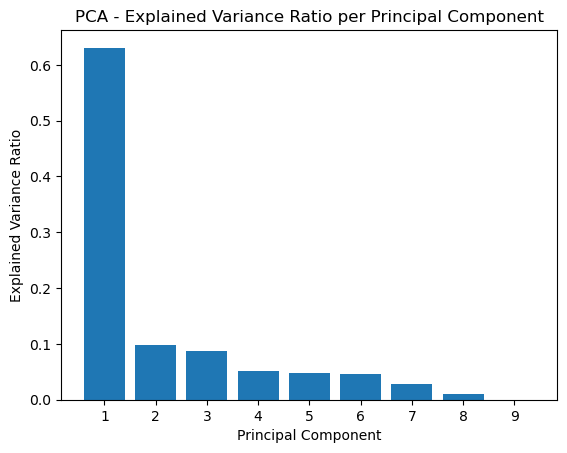

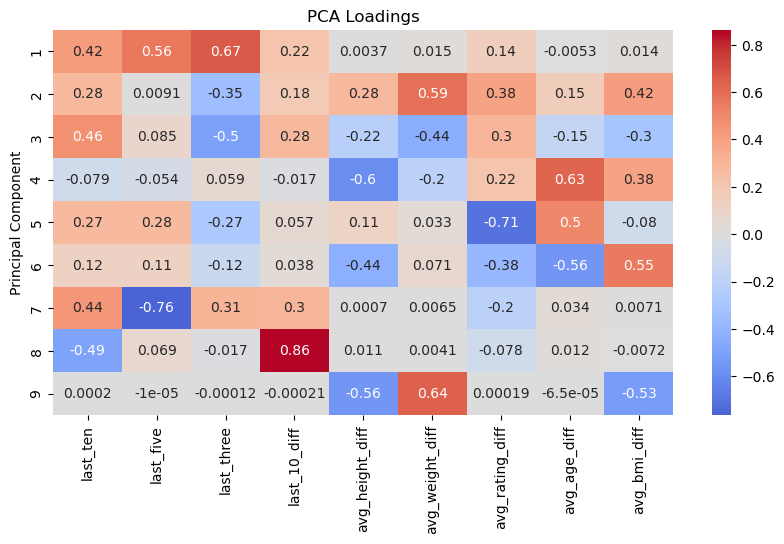

In [9]:
# Perform PCA on the scaled data
pca = PCA()
X_pca = pca.fit_transform(X)

# Determine the explained variance ratio for each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Create a bar chart to visualize the explained variance ratio
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA - Explained Variance Ratio per Principal Component')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.show()

# Extract the PCA loadings (components_)
loadings = pca.components_

# Create a DataFrame with the loadings and feature names
loadings_df = pd.DataFrame(loadings, columns=feature_names)
loadings_df.index.name = 'Principal Component'
loadings_df.index += 1

import seaborn as sns

plt.figure(figsize=(10, 5))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm', center=0)
plt.title("PCA Loadings")
plt.show()


In [10]:
# Baseline models
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()

decision_tree.fit(X_train, y_train)
random_forest.fit(X_train, y_train)

print(decision_tree.score(X_test, y_test))
print(random_forest.score(X_test, y_test))

0.5610384462940944
0.6131589377724931


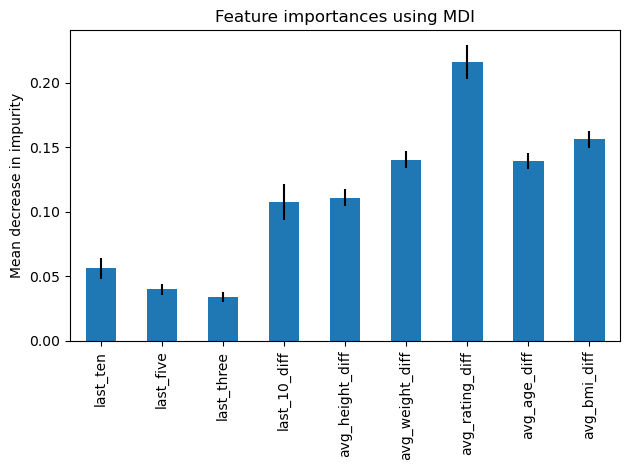

In [11]:
# Feature importance (RF) - based on mean decrease in impurity
importances = random_forest.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
std = np.std([tree.feature_importances_ for tree in random_forest.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)

ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

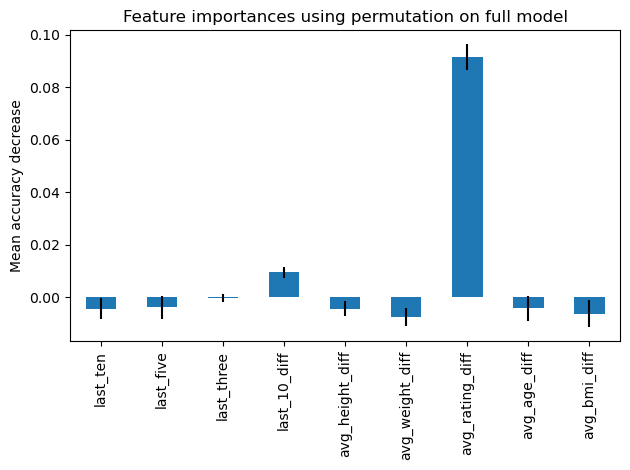

In [12]:

result = permutation_importance(
    random_forest, X_test, y_test) # n_repeats=10, random_state=42, n_jobs=2

forest_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [13]:
from sklearn.inspection import permutation_importance

# Define the objective function for Optuna
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 200)
    max_depth = trial.suggest_int("max_depth", 10, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    
    model = RandomForestClassifier(n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf,
                                   random_state=0)

    score = np.mean(cross_val_score(model, X_train, y_train, cv=5))
    return score

# Create a study object and run the optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# Train the final model with the best hyperparameters
best_params = study.best_params
rf = RandomForestClassifier(**best_params)
rf.fit(X_train, y_train)

# Calculate permutation importance
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=0)

# Display the feature importances
importance_df = pd.DataFrame({'feature': feature_names, 'importance': result.importances_mean})
importance_df = importance_df.sort_values('importance', ascending=False)
print(importance_df)

[I 2023-04-22 21:00:29,702] A new study created in memory with name: no-name-2d5fd9cc-c805-4362-b234-21da229df8ab
[I 2023-04-22 21:00:39,352] Trial 0 finished with value: 0.6238103872719283 and parameters: {'n_estimators': 148, 'max_depth': 21, 'min_samples_split': 7, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.6238103872719283.
[I 2023-04-22 21:00:42,069] Trial 1 finished with value: 0.6131081604179731 and parameters: {'n_estimators': 35, 'max_depth': 36, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.6238103872719283.
[I 2023-04-22 21:00:53,938] Trial 2 finished with value: 0.6204407579691189 and parameters: {'n_estimators': 184, 'max_depth': 30, 'min_samples_split': 8, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.6238103872719283.
[I 2023-04-22 21:01:02,926] Trial 3 finished with value: 0.6230174794092271 and parameters: {'n_estimators': 144, 'max_depth': 25, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 0 with value:

           feature  importance
6  avg_rating_diff    0.100258
3     last_10_diff    0.005113
7     avg_age_diff    0.001189
2       last_three   -0.001585
4  avg_height_diff   -0.001982
0         last_ten   -0.002120
5  avg_weight_diff   -0.002338
1        last_five   -0.003389
8     avg_bmi_diff   -0.003389


In [14]:
test_accuracy = rf.score(X_test, y_test)

print('Best accuracy:', study.best_value)
print('Best parameters:', study.best_params)
print('Accuracy on test data:', test_accuracy)

Best accuracy: 0.6274443264690878
Best parameters: {'n_estimators': 196, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 10}
Accuracy on test data: 0.630400317082838


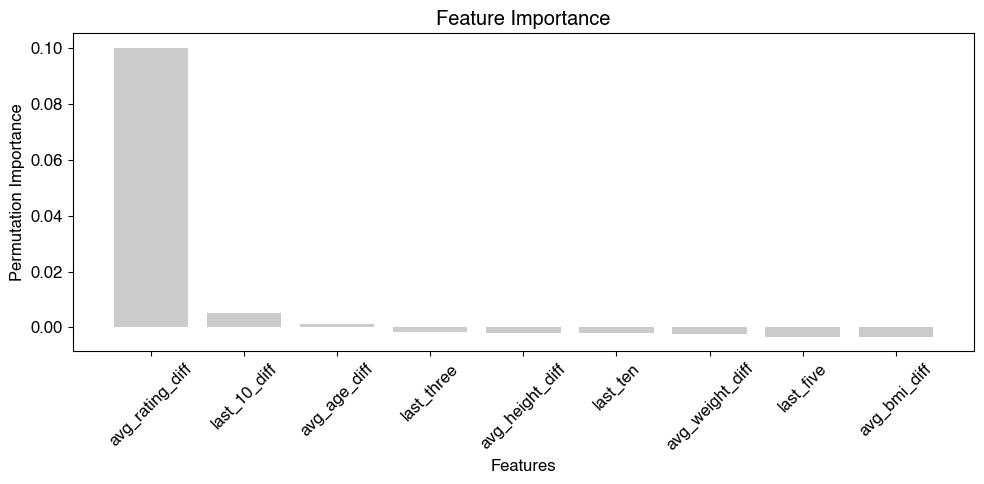

In [15]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Set the font to Helvetica with size 12
rcParams['font.family'] = 'Helvetica'
rcParams['font.size'] = 12

# Plot the feature importances in a bar graph
plt.figure(figsize=(10, 5))
plt.bar(importance_df['feature'], importance_df['importance'], color='#CBCBCB')
plt.xlabel('Features')
plt.ylabel('Permutation Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('data/feature_importance.pdf')
plt.show()


In [16]:
def objective(trial):
    params = {
        'C': trial.suggest_loguniform('C', 1e-5, 1e2),
        'solver': trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
        'random_state': 42
    }

    model = LogisticRegression(**params)
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
    mean_accuracy = scores.mean()

    return mean_accuracy

In [17]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
logistic_regression = LogisticRegression(**best_params)
logistic_regression.fit(X_train, y_train)

test_accuracy = logistic_regression.score(X_test, y_test)

print('Best accuracy:', study.best_value)
print('Best parameters:', study.best_params)
print('Accuracy on test data:', test_accuracy)


[I 2023-04-22 21:02:15,274] A new study created in memory with name: no-name-f7c1127b-6135-45cf-8ec0-e61384e8a06e
[I 2023-04-22 21:02:15,860] Trial 0 finished with value: 0.6366285673873545 and parameters: {'C': 5.28478431386197, 'solver': 'sag', 'max_iter': 436}. Best is trial 0 with value: 0.6366285673873545.
[I 2023-04-22 21:02:15,996] Trial 1 finished with value: 0.6368267616369273 and parameters: {'C': 53.34017080431265, 'solver': 'liblinear', 'max_iter': 881}. Best is trial 1 with value: 0.6368267616369273.
[I 2023-04-22 21:02:18,646] Trial 2 finished with value: 0.63689289914532 and parameters: {'C': 27.591920481598425, 'solver': 'saga', 'max_iter': 720}. Best is trial 2 with value: 0.63689289914532.
[I 2023-04-22 21:02:18,769] Trial 3 finished with value: 0.5380549548125841 and parameters: {'C': 0.0001338023908173466, 'solver': 'lbfgs', 'max_iter': 484}. Best is trial 2 with value: 0.63689289914532.
[I 2023-04-22 21:02:18,891] Trial 4 finished with value: 0.5380549548125841 and

[I 2023-04-22 21:02:46,733] Trial 38 finished with value: 0.6301539454188753 and parameters: {'C': 0.012847079566396512, 'solver': 'sag', 'max_iter': 110}. Best is trial 23 with value: 0.6387418681423261.
[I 2023-04-22 21:02:47,098] Trial 39 finished with value: 0.6368267616369273 and parameters: {'C': 0.33582546826250886, 'solver': 'saga', 'max_iter': 960}. Best is trial 23 with value: 0.6387418681423261.
[I 2023-04-22 21:02:47,274] Trial 40 finished with value: 0.6359678471302432 and parameters: {'C': 1.3054640767403063, 'solver': 'liblinear', 'max_iter': 910}. Best is trial 23 with value: 0.6387418681423261.
[I 2023-04-22 21:02:47,622] Trial 41 finished with value: 0.6378175146091862 and parameters: {'C': 0.05938448201096647, 'solver': 'saga', 'max_iter': 776}. Best is trial 23 with value: 0.6387418681423261.
[I 2023-04-22 21:02:47,957] Trial 42 finished with value: 0.6368264560510799 and parameters: {'C': 0.06651720832178905, 'solver': 'saga', 'max_iter': 725}. Best is trial 23 wit

Best accuracy: 0.6387418681423261
Best parameters: {'C': 0.039599803197853084, 'solver': 'saga', 'max_iter': 921}
Accuracy on test data: 0.6391200951248514


In [18]:
def objective_gnb(trial):
    params = {
        'var_smoothing': trial.suggest_loguniform('var_smoothing', 1e-10, 1e-1)
    }

    model = GaussianNB(**params)
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
    mean_accuracy = scores.mean()

    return mean_accuracy

In [19]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_gnb, n_trials=50)

best_params = study.best_params
gnb = GaussianNB(**best_params)
gnb.fit(X_train, y_train)

test_accuracy = gnb.score(X_test, y_test)

print('Best accuracy:', study.best_value)
print('Best parameters:', study.best_params)
print('Accuracy on test data:', test_accuracy)


[I 2023-04-22 21:02:50,060] A new study created in memory with name: no-name-3a0641f6-9bbe-4d1f-b0a0-2d7004a6d1af
[I 2023-04-22 21:02:50,117] Trial 0 finished with value: 0.6185259673756549 and parameters: {'var_smoothing': 1.7061736231675927e-05}. Best is trial 0 with value: 0.6185259673756549.
[I 2023-04-22 21:02:50,167] Trial 1 finished with value: 0.6185259673756549 and parameters: {'var_smoothing': 8.645493886611358e-06}. Best is trial 0 with value: 0.6185259673756549.
[I 2023-04-22 21:02:50,213] Trial 2 finished with value: 0.6185259673756549 and parameters: {'var_smoothing': 2.3685632235366014e-08}. Best is trial 0 with value: 0.6185259673756549.
[I 2023-04-22 21:02:50,259] Trial 3 finished with value: 0.6185259673756549 and parameters: {'var_smoothing': 7.053188943095669e-08}. Best is trial 0 with value: 0.6185259673756549.
[I 2023-04-22 21:02:50,305] Trial 4 finished with value: 0.6169412864814933 and parameters: {'var_smoothing': 0.09255960886500726}. Best is trial 0 with val

[I 2023-04-22 21:02:52,198] Trial 42 finished with value: 0.6189224431850426 and parameters: {'var_smoothing': 0.005394670622213764}. Best is trial 37 with value: 0.6194512813214581.
[I 2023-04-22 21:02:52,249] Trial 43 finished with value: 0.6191869495634925 and parameters: {'var_smoothing': 0.0164678516750266}. Best is trial 37 with value: 0.6194512813214581.
[I 2023-04-22 21:02:52,290] Trial 44 finished with value: 0.6183276858158401 and parameters: {'var_smoothing': 0.0021097523622333305}. Best is trial 37 with value: 0.6194512813214581.
[I 2023-04-22 21:02:52,347] Trial 45 finished with value: 0.6191867312878871 and parameters: {'var_smoothing': 0.011669190848385308}. Best is trial 37 with value: 0.6194512813214581.
[I 2023-04-22 21:02:52,392] Trial 46 finished with value: 0.6184598298672622 and parameters: {'var_smoothing': 0.0007070342318827544}. Best is trial 37 with value: 0.6194512813214581.
[I 2023-04-22 21:02:52,444] Trial 47 finished with value: 0.6185927597108634 and para

Best accuracy: 0.6194513249765791
Best parameters: {'var_smoothing': 0.01821488720606201}
Accuracy on test data: 0.6198969480776853


In [20]:
from sklearn.neighbors import KNeighborsClassifier

def objective_knn(trial):
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 1, 50),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'p': trial.suggest_int('p', 1, 5)
    }

    model = KNeighborsClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    mean_accuracy = scores.mean()

    return mean_accuracy


In [21]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_knn, n_trials=15)

best_params = study.best_params
k_neighbors = KNeighborsClassifier(**best_params)
k_neighbors.fit(X_train, y_train)

test_accuracy = k_neighbors.score(X_test, y_test)

print('Best accuracy:', study.best_value)
print('Best parameters:', study.best_params)
print('Accuracy on test data:', test_accuracy)


[I 2023-04-22 21:02:52,590] A new study created in memory with name: no-name-966cd815-0be4-4432-ac57-23148b0b0f64
[I 2023-04-22 21:02:53,548] Trial 0 finished with value: 0.6082843139180227 and parameters: {'n_neighbors': 16, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 0.6082843139180227.
[I 2023-04-22 21:02:54,703] Trial 1 finished with value: 0.6163453620192376 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: 0.6163453620192376.
[I 2023-04-22 21:03:01,663] Trial 2 finished with value: 0.6186576644632478 and parameters: {'n_neighbors': 40, 'weights': 'uniform', 'p': 5}. Best is trial 2 with value: 0.6186576644632478.
[I 2023-04-22 21:03:06,901] Trial 3 finished with value: 0.6092101513503086 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'p': 5}. Best is trial 2 with value: 0.6186576644632478.
[I 2023-04-22 21:03:13,091] Trial 4 finished with value: 0.6130419356570259 and parameters: {'n_neighbors': 25, 'weights

Best accuracy: 0.6214329074437503
Best parameters: {'n_neighbors': 50, 'weights': 'uniform', 'p': 5}
Accuracy on test data: 0.6256440745144669


In [22]:
from sklearn.ensemble import AdaBoostClassifier

def objective_adaboost(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1)
    }

    model = AdaBoostClassifier(**params, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    mean_accuracy = scores.mean()

    return mean_accuracy


In [23]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_adaboost, n_trials=5)

best_params = study.best_params
ada_boost = AdaBoostClassifier(**best_params, random_state=42)
ada_boost.fit(X_train, y_train)

test_accuracy = ada_boost.score(X_test, y_test)

print('Best accuracy:', study.best_value)
print('Best parameters:', study.best_params)
print('Accuracy on test data:', test_accuracy)

[I 2023-04-22 21:04:15,154] A new study created in memory with name: no-name-8693a6ca-2eb2-45f1-962d-ee6092f81d6a
[I 2023-04-22 21:04:16,898] Trial 0 finished with value: 0.6334562473624652 and parameters: {'n_estimators': 54, 'learning_rate': 0.22755531465853823}. Best is trial 0 with value: 0.6334562473624652.
[I 2023-04-22 21:04:33,539] Trial 1 finished with value: 0.6371564767816207 and parameters: {'n_estimators': 499, 'learning_rate': 0.001959296662716511}. Best is trial 1 with value: 0.6371564767816207.
[I 2023-04-22 21:04:44,341] Trial 2 finished with value: 0.6371564767816207 and parameters: {'n_estimators': 327, 'learning_rate': 0.003646998412627847}. Best is trial 1 with value: 0.6371564767816207.
[I 2023-04-22 21:04:59,317] Trial 3 finished with value: 0.6302193512460947 and parameters: {'n_estimators': 435, 'learning_rate': 0.3731115096062712}. Best is trial 1 with value: 0.6371564767816207.
[I 2023-04-22 21:05:10,175] Trial 4 finished with value: 0.6343154236268127 and pa

Best accuracy: 0.6371564767816207
Best parameters: {'n_estimators': 499, 'learning_rate': 0.001959296662716511}
Accuracy on test data: 0.6339674990091161


In [24]:
def objective_gradient_boost(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20)
    }

    model = GradientBoostingClassifier(**params, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    mean_accuracy = scores.mean()

    return mean_accuracy


In [25]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_gradient_boost, n_trials=15)

best_params = study.best_params
gradient_boost = GradientBoostingClassifier(**best_params, random_state=42)
gradient_boost.fit(X_train, y_train)

test_accuracy = gradient_boost.score(X_test, y_test)

print('Best accuracy:', study.best_value)
print('Best parameters:', study.best_params)
print('Accuracy on test data:', test_accuracy)


[I 2023-04-22 21:05:14,057] A new study created in memory with name: no-name-109f03a2-2b3c-4c46-a805-ede4cf1e7c43
[I 2023-04-22 21:06:33,715] Trial 0 finished with value: 0.590908965937998 and parameters: {'n_estimators': 420, 'learning_rate': 0.2233987795849722, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.590908965937998.
[I 2023-04-22 21:06:38,772] Trial 1 finished with value: 0.6323997060362506 and parameters: {'n_estimators': 87, 'learning_rate': 0.008450901324551126, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.6323997060362506.
[I 2023-04-22 21:07:03,755] Trial 2 finished with value: 0.6235467538084146 and parameters: {'n_estimators': 157, 'learning_rate': 0.003139096294490983, 'max_depth': 8, 'min_samples_split': 20, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.6323997060362506.
[I 2023-04-22 21:07:34,111] Trial 3 finished with value: 0.5856234881225291 and parameters: {'

Best accuracy: 0.6358349273098696
Best parameters: {'n_estimators': 377, 'learning_rate': 0.04390339951613121, 'max_depth': 1, 'min_samples_split': 10, 'min_samples_leaf': 1}
Accuracy on test data: 0.6369401506143479


In [26]:
# Define the objective function
def objective(trial):
    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'random_state': 42
    }
    model = lgb.LGBMClassifier(**params)
    #model.fit(X_train, y_train)
    #y_pred = model.predict(X_test)
    #accuracy = accuracy_score(y_test, y_pred)
    # Use cross_val_score for cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    mean_accuracy = scores.mean()
    return mean_accuracy

In [27]:
# Define the search space using IntLogUniformDistribution
search_space = {
    'num_leaves': optuna.distributions.IntLogUniformDistribution(2, 256),
    'learning_rate': optuna.distributions.LogUniformDistribution(0.001, 0.1),
    'max_depth': optuna.distributions.IntUniformDistribution(3, 10),
    'feature_fraction': optuna.distributions.UniformDistribution(0.1, 1.0),
    'bagging_fraction': optuna.distributions.UniformDistribution(0.1, 1.0),
    'bagging_freq': optuna.distributions.IntUniformDistribution(1, 10),
    'min_child_samples': optuna.distributions.IntUniformDistribution(5, 100),
}

# Create a study object and run the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2023-04-22 21:11:28,807] A new study created in memory with name: no-name-6cbf9a33-563b-4773-aa10-15dccff4f008


[LightGBM] [Warning] feature_fraction is set=0.37479383862145654, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37479383862145654
[LightGBM] [Warning] bagging_fraction is set=0.2981372092350349, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2981372092350349
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.37479383862145654, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37479383862145654
[LightGBM] [Warning] bagging_fraction is set=0.2981372092350349, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2981372092350349
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.37479383862145654, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37479383862145654
[LightGBM] [Warning] b

[I 2023-04-22 21:11:29,434] Trial 0 finished with value: 0.6123814118551705 and parameters: {'num_leaves': 200, 'learning_rate': 0.004858634106841252, 'max_depth': 10, 'feature_fraction': 0.37479383862145654, 'bagging_fraction': 0.2981372092350349, 'bagging_freq': 2, 'min_child_samples': 67}. Best is trial 0 with value: 0.6123814118551705.


[LightGBM] [Warning] feature_fraction is set=0.37479383862145654, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37479383862145654
[LightGBM] [Warning] bagging_fraction is set=0.2981372092350349, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2981372092350349
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7503428425657264, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7503428425657264
[LightGBM] [Warning] bagging_fraction is set=0.8577671686721183, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8577671686721183
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.7503428425657264, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7503428425657264
[LightGBM] [Warning] baggi

[I 2023-04-22 21:11:30,418] Trial 1 finished with value: 0.5713529140422241 and parameters: {'num_leaves': 79, 'learning_rate': 0.001445024334058625, 'max_depth': 10, 'feature_fraction': 0.7503428425657264, 'bagging_fraction': 0.8577671686721183, 'bagging_freq': 9, 'min_child_samples': 92}. Best is trial 0 with value: 0.6123814118551705.


[LightGBM] [Warning] feature_fraction is set=0.39769250387098665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39769250387098665
[LightGBM] [Warning] bagging_fraction is set=0.9963070226900501, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9963070226900501
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.39769250387098665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39769250387098665
[LightGBM] [Warning] bagging_fraction is set=0.9963070226900501, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9963070226900501
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.39769250387098665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39769250387098665
[LightGBM] [Warning] b

[I 2023-04-22 21:11:31,680] Trial 2 finished with value: 0.6215650514807507 and parameters: {'num_leaves': 253, 'learning_rate': 0.03988035416699559, 'max_depth': 9, 'feature_fraction': 0.39769250387098665, 'bagging_fraction': 0.9963070226900501, 'bagging_freq': 3, 'min_child_samples': 20}. Best is trial 2 with value: 0.6215650514807507.


[LightGBM] [Warning] feature_fraction is set=0.20975035928700242, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20975035928700242
[LightGBM] [Warning] bagging_fraction is set=0.49211635649237884, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49211635649237884
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.20975035928700242, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20975035928700242
[LightGBM] [Warning] bagging_fraction is set=0.49211635649237884, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49211635649237884
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.20975035928700242, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20975035928700242
[LightGBM] [Wa

[I 2023-04-22 21:11:32,162] Trial 3 finished with value: 0.5380549733158945 and parameters: {'num_leaves': 106, 'learning_rate': 0.0012401369888934658, 'max_depth': 8, 'feature_fraction': 0.20975035928700242, 'bagging_fraction': 0.49211635649237884, 'bagging_freq': 10, 'min_child_samples': 75}. Best is trial 2 with value: 0.6215650514807507.


[LightGBM] [Warning] feature_fraction is set=0.20975035928700242, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20975035928700242
[LightGBM] [Warning] bagging_fraction is set=0.49211635649237884, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49211635649237884
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.20975035928700242, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20975035928700242
[LightGBM] [Warning] bagging_fraction is set=0.49211635649237884, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49211635649237884
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.8879312653747177, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8879312653747177
[LightGBM] [Warn

[I 2023-04-22 21:11:32,515] Trial 4 finished with value: 0.632531544588357 and parameters: {'num_leaves': 112, 'learning_rate': 0.015268996816075932, 'max_depth': 6, 'feature_fraction': 0.8879312653747177, 'bagging_fraction': 0.2705364085117027, 'bagging_freq': 7, 'min_child_samples': 51}. Best is trial 4 with value: 0.632531544588357.


[LightGBM] [Warning] feature_fraction is set=0.8879312653747177, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8879312653747177
[LightGBM] [Warning] bagging_fraction is set=0.2705364085117027, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2705364085117027
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8879312653747177, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8879312653747177
[LightGBM] [Warning] bagging_fraction is set=0.2705364085117027, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2705364085117027
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.859233398216128, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.859233398216128
[LightGBM] [Warning] bagging_f

[I 2023-04-22 21:11:32,838] Trial 5 finished with value: 0.6300211570109437 and parameters: {'num_leaves': 78, 'learning_rate': 0.052605185820975134, 'max_depth': 4, 'feature_fraction': 0.859233398216128, 'bagging_fraction': 0.33302898899917377, 'bagging_freq': 5, 'min_child_samples': 11}. Best is trial 4 with value: 0.632531544588357.


[LightGBM] [Warning] feature_fraction is set=0.9249610028849325, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9249610028849325
[LightGBM] [Warning] bagging_fraction is set=0.7547769239383052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7547769239383052
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9249610028849325, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9249610028849325
[LightGBM] [Warning] bagging_fraction is set=0.7547769239383052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7547769239383052
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9249610028849325, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9249610028849325
[LightGBM] [Warning] bagging

[I 2023-04-22 21:11:34,439] Trial 6 finished with value: 0.6213005015625553 and parameters: {'num_leaves': 207, 'learning_rate': 0.03612338721367723, 'max_depth': 10, 'feature_fraction': 0.9249610028849325, 'bagging_fraction': 0.7547769239383052, 'bagging_freq': 4, 'min_child_samples': 12}. Best is trial 4 with value: 0.632531544588357.


[LightGBM] [Warning] feature_fraction is set=0.6253553041551213, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6253553041551213
[LightGBM] [Warning] bagging_fraction is set=0.5481109413037353, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5481109413037353
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6253553041551213, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6253553041551213
[LightGBM] [Warning] bagging_fraction is set=0.5481109413037353, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5481109413037353
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6253553041551213, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6253553041551213
[LightGBM] [Warning] bagging

[I 2023-04-22 21:11:34,670] Trial 7 finished with value: 0.6320031866438514 and parameters: {'num_leaves': 67, 'learning_rate': 0.009823347973612402, 'max_depth': 3, 'feature_fraction': 0.6253553041551213, 'bagging_fraction': 0.5481109413037353, 'bagging_freq': 5, 'min_child_samples': 64}. Best is trial 4 with value: 0.632531544588357.


[LightGBM] [Warning] feature_fraction is set=0.7955458524750908, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7955458524750908
[LightGBM] [Warning] bagging_fraction is set=0.6464790646034404, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6464790646034404
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7955458524750908, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7955458524750908
[LightGBM] [Warning] bagging_fraction is set=0.6464790646034404, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6464790646034404
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7955458524750908, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7955458524750908
[LightGBM] [Warning] bagging

[I 2023-04-22 21:11:35,224] Trial 8 finished with value: 0.634381844770906 and parameters: {'num_leaves': 40, 'learning_rate': 0.010168163173625119, 'max_depth': 10, 'feature_fraction': 0.7955458524750908, 'bagging_fraction': 0.6464790646034404, 'bagging_freq': 2, 'min_child_samples': 59}. Best is trial 8 with value: 0.634381844770906.


[LightGBM] [Warning] feature_fraction is set=0.3985539686776275, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3985539686776275
[LightGBM] [Warning] bagging_fraction is set=0.9333687759814118, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9333687759814118
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.3985539686776275, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3985539686776275
[LightGBM] [Warning] bagging_fraction is set=0.9333687759814118, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9333687759814118
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.3985539686776275, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3985539686776275
[LightGBM] [Warning] bagging

[I 2023-04-22 21:11:35,583] Trial 9 finished with value: 0.5827825440694692 and parameters: {'num_leaves': 16, 'learning_rate': 0.0021698023372744898, 'max_depth': 7, 'feature_fraction': 0.3985539686776275, 'bagging_fraction': 0.9333687759814118, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 8 with value: 0.634381844770906.


[LightGBM] [Warning] feature_fraction is set=0.3985539686776275, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3985539686776275
[LightGBM] [Warning] bagging_fraction is set=0.9333687759814118, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9333687759814118
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.3985539686776275, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3985539686776275
[LightGBM] [Warning] bagging_fraction is set=0.9333687759814118, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9333687759814118
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6817759344455977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6817759344455977
[LightGBM] [Warning] bagging

[I 2023-04-22 21:11:35,929] Trial 10 finished with value: 0.6250003382154183 and parameters: {'num_leaves': 9, 'learning_rate': 0.00487475030089943, 'max_depth': 6, 'feature_fraction': 0.6817759344455977, 'bagging_fraction': 0.7066173104938918, 'bagging_freq': 1, 'min_child_samples': 43}. Best is trial 8 with value: 0.634381844770906.


[LightGBM] [Warning] feature_fraction is set=0.9907891773683827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9907891773683827
[LightGBM] [Warning] bagging_fraction is set=0.10577649325016217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10577649325016217
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.9907891773683827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9907891773683827
[LightGBM] [Warning] bagging_fraction is set=0.10577649325016217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10577649325016217
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.9907891773683827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9907891773683827
[LightGBM] [Warning] bag

[I 2023-04-22 21:11:36,212] Trial 11 finished with value: 0.630945663401906 and parameters: {'num_leaves': 158, 'learning_rate': 0.017522959882444927, 'max_depth': 5, 'feature_fraction': 0.9907891773683827, 'bagging_fraction': 0.10577649325016217, 'bagging_freq': 7, 'min_child_samples': 44}. Best is trial 8 with value: 0.634381844770906.


[LightGBM] [Warning] feature_fraction is set=0.9907891773683827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9907891773683827
[LightGBM] [Warning] bagging_fraction is set=0.10577649325016217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10577649325016217
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8057485088226897, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8057485088226897
[LightGBM] [Warning] bagging_fraction is set=0.6305564637397381, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6305564637397381
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.8057485088226897, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8057485088226897
[LightGBM] [Warning] baggi

[I 2023-04-22 21:11:36,775] Trial 12 finished with value: 0.633192395695456 and parameters: {'num_leaves': 139, 'learning_rate': 0.016339791804698637, 'max_depth': 7, 'feature_fraction': 0.8057485088226897, 'bagging_fraction': 0.6305564637397381, 'bagging_freq': 8, 'min_child_samples': 54}. Best is trial 8 with value: 0.634381844770906.


[LightGBM] [Warning] feature_fraction is set=0.8057485088226897, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8057485088226897
[LightGBM] [Warning] bagging_fraction is set=0.6305564637397381, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6305564637397381
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.7724197969025735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7724197969025735
[LightGBM] [Warning] bagging_fraction is set=0.6699076409884697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6699076409884697
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.7724197969025735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7724197969025735
[LightGBM] [Warning] bagging

[I 2023-04-22 21:11:37,369] Trial 13 finished with value: 0.616675242064048 and parameters: {'num_leaves': 155, 'learning_rate': 0.09219591166636995, 'max_depth': 8, 'feature_fraction': 0.7724197969025735, 'bagging_fraction': 0.6699076409884697, 'bagging_freq': 8, 'min_child_samples': 34}. Best is trial 8 with value: 0.634381844770906.


[LightGBM] [Warning] feature_fraction is set=0.5689704922772889, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5689704922772889
[LightGBM] [Warning] bagging_fraction is set=0.6060344826521054, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6060344826521054
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5689704922772889, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5689704922772889
[LightGBM] [Warning] bagging_fraction is set=0.6060344826521054, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6060344826521054
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5689704922772889, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5689704922772889
[LightGBM] [Warning] bagging

[I 2023-04-22 21:11:38,064] Trial 14 finished with value: 0.6293606332090882 and parameters: {'num_leaves': 45, 'learning_rate': 0.009101709648845522, 'max_depth': 8, 'feature_fraction': 0.5689704922772889, 'bagging_fraction': 0.6060344826521054, 'bagging_freq': 1, 'min_child_samples': 84}. Best is trial 8 with value: 0.634381844770906.


[LightGBM] [Warning] feature_fraction is set=0.5689704922772889, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5689704922772889
[LightGBM] [Warning] bagging_fraction is set=0.6060344826521054, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6060344826521054
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7809123299462415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7809123299462415
[LightGBM] [Warning] bagging_fraction is set=0.5017507385039879, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5017507385039879
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7809123299462415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7809123299462415
[LightGBM] [Warning] bagging

[I 2023-04-22 21:11:38,642] Trial 15 finished with value: 0.6325319155342997 and parameters: {'num_leaves': 149, 'learning_rate': 0.020233334560928906, 'max_depth': 7, 'feature_fraction': 0.7809123299462415, 'bagging_fraction': 0.5017507385039879, 'bagging_freq': 3, 'min_child_samples': 59}. Best is trial 8 with value: 0.634381844770906.


[LightGBM] [Warning] feature_fraction is set=0.7809123299462415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7809123299462415
[LightGBM] [Warning] bagging_fraction is set=0.5017507385039879, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5017507385039879
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7809123299462415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7809123299462415
[LightGBM] [Warning] bagging_fraction is set=0.5017507385039879, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5017507385039879
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6916096257665585, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6916096257665585
[LightGBM] [Warning] bagging

[I 2023-04-22 21:11:39,578] Trial 16 finished with value: 0.6277090727704294 and parameters: {'num_leaves': 188, 'learning_rate': 0.00585148316717424, 'max_depth': 9, 'feature_fraction': 0.6916096257665585, 'bagging_fraction': 0.8013708729985052, 'bagging_freq': 10, 'min_child_samples': 76}. Best is trial 8 with value: 0.634381844770906.


[LightGBM] [Warning] feature_fraction is set=0.6916096257665585, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6916096257665585
[LightGBM] [Warning] bagging_fraction is set=0.8013708729985052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8013708729985052
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.8363194895360393, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8363194895360393
[LightGBM] [Warning] bagging_fraction is set=0.6367930889068709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6367930889068709
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.8363194895360393, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8363194895360393
[LightGBM] [Warning] baggi

[I 2023-04-22 21:11:39,987] Trial 17 finished with value: 0.6336548343639083 and parameters: {'num_leaves': 123, 'learning_rate': 0.025859160022900004, 'max_depth': 5, 'feature_fraction': 0.8363194895360393, 'bagging_fraction': 0.6367930889068709, 'bagging_freq': 8, 'min_child_samples': 52}. Best is trial 8 with value: 0.634381844770906.


[LightGBM] [Warning] feature_fraction is set=0.8363194895360393, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8363194895360393
[LightGBM] [Warning] bagging_fraction is set=0.6367930889068709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6367930889068709
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.9886474322233495, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9886474322233495
[LightGBM] [Warning] bagging_fraction is set=0.8180475611676689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8180475611676689
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9886474322233495, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9886474322233495
[LightGBM] [Warning] bagging

[I 2023-04-22 21:11:40,433] Trial 18 finished with value: 0.635042346752412 and parameters: {'num_leaves': 41, 'learning_rate': 0.031993079161054705, 'max_depth': 5, 'feature_fraction': 0.9886474322233495, 'bagging_fraction': 0.8180475611676689, 'bagging_freq': 4, 'min_child_samples': 39}. Best is trial 18 with value: 0.635042346752412.


[LightGBM] [Warning] feature_fraction is set=0.9886474322233495, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9886474322233495
[LightGBM] [Warning] bagging_fraction is set=0.8180475611676689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8180475611676689
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9676012519662545, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9676012519662545
[LightGBM] [Warning] bagging_fraction is set=0.8398406634751167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8398406634751167
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9676012519662545, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9676012519662545
[LightGBM] [Warning] bagging

[I 2023-04-22 21:11:40,706] Trial 19 finished with value: 0.6353064820839656 and parameters: {'num_leaves': 39, 'learning_rate': 0.06960178385235456, 'max_depth': 3, 'feature_fraction': 0.9676012519662545, 'bagging_fraction': 0.8398406634751167, 'bagging_freq': 3, 'min_child_samples': 40}. Best is trial 19 with value: 0.6353064820839656.


[LightGBM] [Warning] feature_fraction is set=0.9676012519662545, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9676012519662545
[LightGBM] [Warning] bagging_fraction is set=0.8398406634751167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8398406634751167
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9676012519662545, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9676012519662545
[LightGBM] [Warning] bagging_fraction is set=0.8398406634751167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8398406634751167
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9676012519662545, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9676012519662545
[LightGBM] [Warning] bagging

[I 2023-04-22 21:11:40,974] Trial 20 finished with value: 0.6322014463400509 and parameters: {'num_leaves': 41, 'learning_rate': 0.09564700400924293, 'max_depth': 3, 'feature_fraction': 0.9993750356717164, 'bagging_fraction': 0.8639965911985961, 'bagging_freq': 4, 'min_child_samples': 31}. Best is trial 19 with value: 0.6353064820839656.


[LightGBM] [Warning] feature_fraction is set=0.9993750356717164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9993750356717164
[LightGBM] [Warning] bagging_fraction is set=0.8639965911985961, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8639965911985961
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9993750356717164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9993750356717164
[LightGBM] [Warning] bagging_fraction is set=0.8639965911985961, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8639965911985961
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9993750356717164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9993750356717164
[LightGBM] [Warning] bagging

[I 2023-04-22 21:11:41,304] Trial 21 finished with value: 0.6341829959252678 and parameters: {'num_leaves': 33, 'learning_rate': 0.04807101655526714, 'max_depth': 4, 'feature_fraction': 0.9254939584135865, 'bagging_fraction': 0.7821762997941909, 'bagging_freq': 3, 'min_child_samples': 40}. Best is trial 19 with value: 0.6353064820839656.


[LightGBM] [Warning] feature_fraction is set=0.9254939584135865, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9254939584135865
[LightGBM] [Warning] bagging_fraction is set=0.7821762997941909, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7821762997941909
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9136464009448134, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9136464009448134
[LightGBM] [Warning] bagging_fraction is set=0.7340554728354094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7340554728354094
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9136464009448134, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9136464009448134
[LightGBM] [Warning] bagging

[I 2023-04-22 21:11:41,654] Trial 22 finished with value: 0.6345796244194151 and parameters: {'num_leaves': 58, 'learning_rate': 0.02657229768738756, 'max_depth': 4, 'feature_fraction': 0.9136464009448134, 'bagging_fraction': 0.7340554728354094, 'bagging_freq': 2, 'min_child_samples': 35}. Best is trial 19 with value: 0.6353064820839656.


[LightGBM] [Warning] feature_fraction is set=0.9136464009448134, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9136464009448134
[LightGBM] [Warning] bagging_fraction is set=0.7340554728354094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7340554728354094
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9136464009448134, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9136464009448134
[LightGBM] [Warning] bagging_fraction is set=0.7340554728354094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7340554728354094
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9136464009448134, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9136464009448134
[LightGBM] [Warning] bagging

[I 2023-04-22 21:11:41,857] Trial 23 finished with value: 0.6365615885912739 and parameters: {'num_leaves': 2, 'learning_rate': 0.06066366363112414, 'max_depth': 4, 'feature_fraction': 0.9962937392276853, 'bagging_fraction': 0.8691845579720832, 'bagging_freq': 4, 'min_child_samples': 22}. Best is trial 23 with value: 0.6365615885912739.


[LightGBM] [Warning] feature_fraction is set=0.9962937392276853, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9962937392276853
[LightGBM] [Warning] bagging_fraction is set=0.8691845579720832, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8691845579720832
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9962937392276853, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9962937392276853
[LightGBM] [Warning] bagging_fraction is set=0.8691845579720832, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8691845579720832
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9962937392276853, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9962937392276853
[LightGBM] [Warning] bagging

[I 2023-04-22 21:11:42,129] Trial 24 finished with value: 0.6360991062821223 and parameters: {'num_leaves': 6, 'learning_rate': 0.06319169310571782, 'max_depth': 5, 'feature_fraction': 0.9855706737851935, 'bagging_fraction': 0.8879327520523275, 'bagging_freq': 4, 'min_child_samples': 21}. Best is trial 23 with value: 0.6365615885912739.


[LightGBM] [Warning] feature_fraction is set=0.9855706737851935, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9855706737851935
[LightGBM] [Warning] bagging_fraction is set=0.8879327520523275, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8879327520523275
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9855706737851935, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9855706737851935
[LightGBM] [Warning] bagging_fraction is set=0.8879327520523275, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8879327520523275
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9855706737851935, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9855706737851935
[LightGBM] [Warning] bagging

[I 2023-04-22 21:11:42,322] Trial 25 finished with value: 0.6368258330245755 and parameters: {'num_leaves': 2, 'learning_rate': 0.06429311352428914, 'max_depth': 3, 'feature_fraction': 0.87290135325463, 'bagging_fraction': 0.8964816737389931, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 25 with value: 0.6368258330245755.


[LightGBM] [Warning] feature_fraction is set=0.87290135325463, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.87290135325463
[LightGBM] [Warning] bagging_fraction is set=0.8964816737389931, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8964816737389931
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.87290135325463, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.87290135325463
[LightGBM] [Warning] bagging_fraction is set=0.8964816737389931, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8964816737389931
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.87290135325463, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.87290135325463
[LightGBM] [Warning] bagging_fraction is

[I 2023-04-22 21:11:42,686] Trial 26 finished with value: 0.636363437996822 and parameters: {'num_leaves': 10, 'learning_rate': 0.06343677130680767, 'max_depth': 4, 'feature_fraction': 0.8967197369312879, 'bagging_fraction': 0.9371800870688113, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 25 with value: 0.6368258330245755.


[LightGBM] [Warning] feature_fraction is set=0.8650075623198953, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8650075623198953
[LightGBM] [Warning] bagging_fraction is set=0.9915916274550651, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9915916274550651
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8650075623198953, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8650075623198953
[LightGBM] [Warning] bagging_fraction is set=0.9915916274550651, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9915916274550651
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8650075623198953, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8650075623198953
[LightGBM] [Warning] bagging

[I 2023-04-22 21:11:43,088] Trial 27 finished with value: 0.6325317409715031 and parameters: {'num_leaves': 20, 'learning_rate': 0.06861111463625312, 'max_depth': 4, 'feature_fraction': 0.8650075623198953, 'bagging_fraction': 0.9915916274550651, 'bagging_freq': 6, 'min_child_samples': 6}. Best is trial 25 with value: 0.6368258330245755.


[LightGBM] [Warning] feature_fraction is set=0.8650075623198953, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8650075623198953
[LightGBM] [Warning] bagging_fraction is set=0.9915916274550651, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9915916274550651
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8650075623198953, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8650075623198953
[LightGBM] [Warning] bagging_fraction is set=0.9915916274550651, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9915916274550651
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8787392799777766, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8787392799777766
[LightGBM] [Warning] bagging

[I 2023-04-22 21:11:43,328] Trial 28 finished with value: 0.6359670277061708 and parameters: {'num_leaves': 4, 'learning_rate': 0.04345577890385151, 'max_depth': 3, 'feature_fraction': 0.8787392799777766, 'bagging_fraction': 0.9283093474096479, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 25 with value: 0.6368258330245755.


[LightGBM] [Warning] feature_fraction is set=0.8787392799777766, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8787392799777766
[LightGBM] [Warning] bagging_fraction is set=0.9283093474096479, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9283093474096479
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8787392799777766, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8787392799777766
[LightGBM] [Warning] bagging_fraction is set=0.9283093474096479, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9283093474096479
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8787392799777766, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8787392799777766
[LightGBM] [Warning] bagging

[I 2023-04-22 21:11:43,665] Trial 29 finished with value: 0.6341832577694628 and parameters: {'num_leaves': 82, 'learning_rate': 0.05539262604014012, 'max_depth': 4, 'feature_fraction': 0.7260134049724873, 'bagging_fraction': 0.9209109565943387, 'bagging_freq': 6, 'min_child_samples': 15}. Best is trial 25 with value: 0.6368258330245755.


In [29]:
# Train the final model with the best hyperparameters
best_params = study.best_params
lgbm = lgb.LGBMClassifier(**best_params)
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)
accuracy_lgbm = accuracy_score(y_test, y_pred)

# Print the results
print('Best accuracy:', study.best_value)
print('Best parameters:', study.best_params)
print('Accuracy on test data:', accuracy_lgbm)

Best accuracy: 0.6368258330245755
Best parameters: {'num_leaves': 2, 'learning_rate': 0.06429311352428914, 'max_depth': 3, 'feature_fraction': 0.87290135325463, 'bagging_fraction': 0.8964816737389931, 'bagging_freq': 5, 'min_child_samples': 5}
Accuracy on test data: 0.6397146254458977


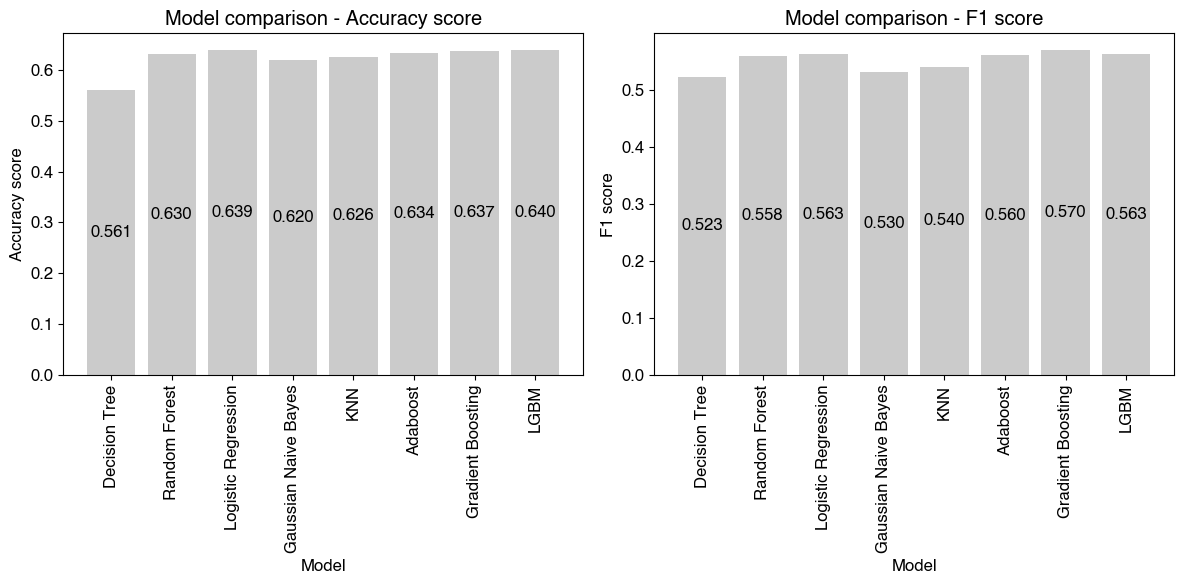

In [30]:
# Set the font to Helvetica with size 12
rcParams['font.family'] = 'Helvetica'
rcParams['font.size'] = 12

# Define the models and scores
model_names = ['Decision Tree', 'Random Forest', 'Logistic Regression', 'Gaussian Naive Bayes', 'KNN', 
               'Adaboost', 'Gradient Boosting', 'LGBM']
accuracy_scores = [decision_tree.score(X_test, y_test), rf.score(X_test, y_test), logistic_regression.score(X_test, y_test), 
          gnb.score(X_test, y_test), k_neighbors.score(X_test, y_test), ada_boost.score(X_test, y_test),
          gradient_boost.score(X_test, y_test), accuracy_lgbm]
f1_scores = [f1_score(y_test, decision_tree.predict(X_test)), f1_score(y_test, rf.predict(X_test)), 
             f1_score(y_test, logistic_regression.predict(X_test)), f1_score(y_test, gnb.predict(X_test)), 
             f1_score(y_test, k_neighbors.predict(X_test)), f1_score(y_test, ada_boost.predict(X_test)), 
             f1_score(y_test, gradient_boost.predict(X_test)), f1_score(y_test, lgbm.predict(X_test))]

# Create a subplot with two columns
fig, ax = plt.subplots(figsize=(12,6), ncols=2)

# Plot the accuracy scores in the first column
ax[0].bar(model_names, accuracy_scores, color='#CBCBCB')
ax[0].set_xlabel('Model')
ax[0].set_ylabel('Accuracy score')
ax[0].set_title('Model comparison - Accuracy score')
for i in range(len(model_names)):
    ax[0].text(i, accuracy_scores[i]/2, '{:.3f}'.format(accuracy_scores[i]), ha='center', va='center')
ax[0].tick_params(axis='x', rotation=90)

# Plot the F1 scores in the second column
ax[1].bar(model_names, f1_scores, color='#CBCBCB')
ax[1].set_xlabel('Model')
ax[1].set_ylabel('F1 score')
ax[1].set_title('Model comparison - F1 score')
for i in range(len(model_names)):
    ax[1].text(i, f1_scores[i]/2, '{:.3f}'.format(f1_scores[i]), ha='center', va='center')
ax[1].tick_params(axis='x', rotation=90)

# Set tight layout
fig.tight_layout()

# Export the figure as PDF
fig.savefig('data/model_scores.pdf', bbox_inches='tight')


In [31]:
import random
from itertools import combinations

def train_evaluate_adaboost(features):
    X = df_main_nn[features].values
    y = df_main_nn['outcome'].values

    scaler = preprocessing.MinMaxScaler().fit(X)
    X = scaler.transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective_adaboost, n_trials=5)

    best_params = study.best_params
    ada_boost = AdaBoostClassifier(**best_params, random_state=42)
    ada_boost.fit(X_train, y_train)

    y_pred = ada_boost.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    return accuracy, f1

# Initial set of features
features_sets = [
    ["avg_rating_diff"],
    ["avg_rating_diff", "last_10_diff", "last_three", "avg_age_diff", "last_five", "last_ten"]
]

# Generate 6 random combinations
all_features = ["last_ten","last_five","last_three",  'last_10_diff', 
                "avg_height_diff", "avg_weight_diff", "avg_rating_diff",
                "avg_age_diff", "avg_bmi_diff"]

for _ in range(6):
    k = random.randint(1, len(all_features))
    random_combination = random.sample(all_features, k)
    features_sets.append(random_combination)

# Evaluate the models with the given sets of features
accuracy_scores = []
f1_scores = []
model_names = []

for idx, features in enumerate(features_sets):
    accuracy, f1 = train_evaluate_adaboost(features)
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    model_names.append(f'Model {idx + 1}')


[I 2023-04-22 21:32:10,520] A new study created in memory with name: no-name-9c2d2434-fce0-43c9-9356-a31d76b56134
[I 2023-04-22 21:32:24,583] Trial 0 finished with value: 0.6367598482874735 and parameters: {'n_estimators': 426, 'learning_rate': 0.016388044431167086}. Best is trial 0 with value: 0.6367598482874735.
[I 2023-04-22 21:32:41,402] Trial 1 finished with value: 0.6371564767816207 and parameters: {'n_estimators': 481, 'learning_rate': 0.002781373234579825}. Best is trial 1 with value: 0.6371564767816207.
[I 2023-04-22 21:32:48,759] Trial 2 finished with value: 0.6367598482874735 and parameters: {'n_estimators': 210, 'learning_rate': 0.03289714440120587}. Best is trial 1 with value: 0.6371564767816207.
[I 2023-04-22 21:32:52,737] Trial 3 finished with value: 0.6335225375844612 and parameters: {'n_estimators': 114, 'learning_rate': 0.22231148781979954}. Best is trial 1 with value: 0.6371564767816207.
[I 2023-04-22 21:33:07,599] Trial 4 finished with value: 0.6371564767816207 and 

[I 2023-04-22 21:37:37,095] A new study created in memory with name: no-name-71ab1be3-9a0d-4a72-8bd7-fd018639b03e
[I 2023-04-22 21:37:43,891] Trial 0 finished with value: 0.6345796025990655 and parameters: {'n_estimators': 193, 'learning_rate': 0.009733196627112925}. Best is trial 0 with value: 0.6345796025990655.
[I 2023-04-22 21:37:49,195] Trial 1 finished with value: 0.6345796462397646 and parameters: {'n_estimators': 153, 'learning_rate': 0.104103977078971}. Best is trial 1 with value: 0.6345796462397646.
[I 2023-04-22 21:37:49,591] Trial 2 finished with value: 0.6348439561341148 and parameters: {'n_estimators': 11, 'learning_rate': 0.08334105136281221}. Best is trial 2 with value: 0.6348439561341148.
[I 2023-04-22 21:37:50,019] Trial 3 finished with value: 0.6348439561341148 and parameters: {'n_estimators': 13, 'learning_rate': 0.06211999738418666}. Best is trial 2 with value: 0.6348439561341148.
[I 2023-04-22 21:37:56,341] Trial 4 finished with value: 0.6312760671351059 and param

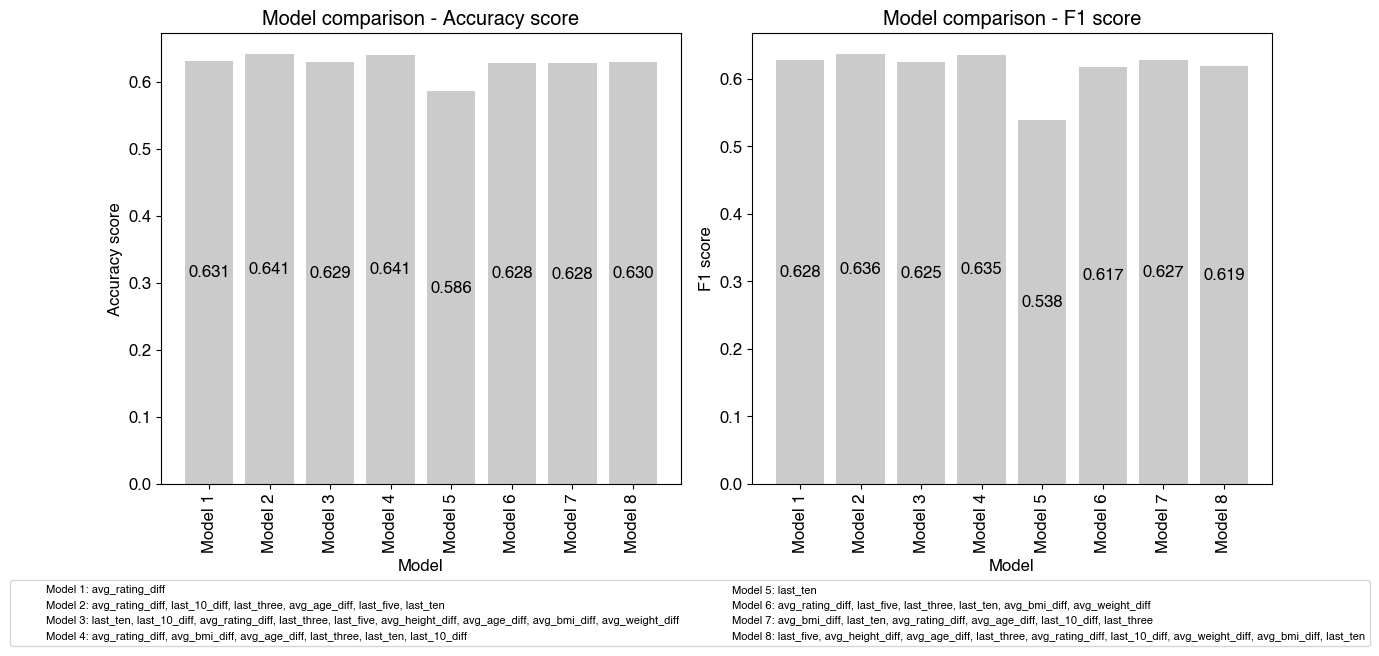

In [42]:
import matplotlib.patches as mpatches

# Create a subplot with two columns
fig, ax = plt.subplots(figsize=(12,6), ncols=2)

# Plot the accuracy scores in the first column
ax[0].bar(model_names, accuracy_scores, color='#CBCBCB')
ax[0].set_xlabel('Model')
ax[0].set_ylabel('Accuracy score')
ax[0].set_title('Model comparison - Accuracy score')
for i in range(len(model_names)):
    ax[0].text(i, accuracy_scores[i]/2, '{:.3f}'.format(accuracy_scores[i]), ha='center', va='center')
ax[0].tick_params(axis='x', rotation=90)

# Plot the F1 scores in the second column
ax[1].bar(model_names, f1_scores, color='#CBCBCB')
ax[1].set_xlabel('Model')
ax[1].set_ylabel('F1 score')
ax[1].set_title('Model comparison - F1 score')
for i in range(len(model_names)):
    ax[1].text(i, f1_scores[i]/2, '{:.3f}'.format(f1_scores[i]), ha='center', va='center')
ax[1].tick_params(axis='x', rotation=90)

# Set tight layout
fig.tight_layout()

# Create the legend patches
legend_patches = [mpatches.Patch(color='none', label=f'Model {idx + 1}: {", ".join(features_sets[idx])}', linewidth=0) for idx in range(len(features_sets))]

# Add the legend below the plot
lgd = fig.legend(handles=legend_patches, loc='lower center', ncol=2, fontsize=8, bbox_to_anchor=(0.5, -0.1))

# Export the figure as PDF
fig.savefig('data/model_scores_new.pdf', bbox_inches='tight', bbox_extra_artists=[lgd])

# Show the plot
plt.show()
